In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('ggplot')
# figure size in inches
rcParams['figure.figsize'] = 8, 4

sns.set(font_scale=1.5)

import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [15]:
path = '../data/all-data/'
df = pd.read_csv(f'{path}intrusion_detection_data_v1.csv')
df.shape

(928344, 70)

In [16]:
# Create train, test split
train, test = train_test_split(df, train_size=0.7, random_state=123, stratify=df.label.values)
print(f'Train size: {train.shape[0]}')
print(f'Test size: {test.shape[0]}')

Train size: 649840
Test size: 278504


In [17]:
# Split train and test into features and target.
X_train = train.iloc[:, :-2]
y_train = train['label']

X_test = test.iloc[:, :-2]
y_test = test['label']

In [18]:
# Standarize numaric features.
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
x_test_std = scaler.fit_transform(X_test)

# One-hot encode labels.
ohe = OneHotEncoder()
ohe.fit(y_train.values.reshape(-1, 1))
y_train_ohe = ohe.transform(y_train.values.reshape(-1, 1)).toarray()
y_test_ohe = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

In [19]:
# Save the transformed scaler and one-hot encoder.
joblib.dump(ohe, '../../assets/one-hot-ecoder')
joblib.dump(scaler, '../../assets/standard-scaler')

['../../assets/standard-scaler']

#### Logistic Regression

In [11]:
# Define Logistic Regression model.
lr_model = LogisticRegression(solver='sag', dual=False, max_iter=1000)

# Train the model.
lr_model = lr_model.fit(X_train_std, y_train)

# Test the model.
y_pred = lr_model.predict(x_test_std)
print(classification_report(y_test, y_pred))

c:\Python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


              precision    recall  f1-score   support

      benign       0.97      0.96      0.97    150796
         bot       1.00      0.02      0.04       584
 brute_force       0.91      0.45      0.60      2745
        ddos       0.87      1.00      0.93     38404
         dos       0.96      0.92      0.94     58124
    portscan       0.97      0.99      0.98     27208
  web_attack       0.71      0.03      0.07       643

    accuracy                           0.95    278504
   macro avg       0.91      0.63      0.65    278504
weighted avg       0.95      0.95      0.95    278504



#### Linear SVC

In [8]:
# Define Linear SVC model object.
l_svm_model = LinearSVC(dual=False)

# Train the model.
l_svm_model.fit(X_train_std, y_train)

# Test the model.
y_pred = l_svm_model.predict(x_test_std)
print(classification_report(y_test, y_pred))

c:\Python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

      benign       0.98      0.99      0.98    150796
         bot       0.25      0.02      0.04       584
 brute_force       0.95      0.96      0.96      2745
        ddos       0.97      1.00      0.98     38404
         dos       0.99      0.97      0.98     58124
    portscan       0.98      1.00      0.99     27208
  web_attack       0.17      0.04      0.07       643

    accuracy                           0.98    278504
   macro avg       0.76      0.71      0.71    278504
weighted avg       0.98      0.98      0.98    278504



#### KNN

In [6]:
# Define KNN model object.
knn_model = KNeighborsClassifier(n_neighbors=50)

# Train the model.
knn_model.fit(X_train_std, y_train_ohe)

# Test the model.
y_pred = knn_model.predict(x_test_std)
print(classification_report(y_test_ohe, y_pred, target_names=ohe.categories_[0]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    150796
           1       0.95      0.70      0.81       584
           2       0.99      0.97      0.98      2745
           3       1.00      0.99      0.99     38404
           4       0.99      1.00      0.99     58124
           5       1.00      1.00      1.00     27208
           6       0.94      0.89      0.91       643

   micro avg       0.99      0.99      0.99    278504
   macro avg       0.98      0.94      0.95    278504
weighted avg       0.99      0.99      0.99    278504
 samples avg       0.99      0.99      0.99    278504



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Save KNN trained model.
file_name = '../../assets/model/knn_model.sav'
joblib.dump(knn_model, file_name)

['../assets/model/knn_model.sav']

In [ ]:
# Test KNN trained model on new data.
file_name = '../../assets/model/knn_model.sav'
test_data = '../data/all-data/test_data.csv'
test_data_df = pd.read_csv(test_data)
test_data_X_std = scaler.transform(test_data_df)

loaded_model = joblib.load(file_name)
y_pred = loaded_model.predict(test_data_X_std)

In [12]:
ohe.inverse_transform(y_pred)

array([['dos'],
       ['benign'],
       ['dos'],
       ['benign'],
       ['benign'],
       ['benign'],
       ['benign'],
       ['benign'],
       ['benign'],
       ['dos']], dtype=object)

#### DNN

In [21]:
# Define a sequential model object.
seq_model = Sequential()

seq_model.add(Dense(units=128, input_dim=X_train_std.shape[1], activation = 'relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(units=64, activation='relu'))
seq_model.add(Dense(units=32, activation='relu'))
seq_model.add(Dense(units=7, activation='softmax'))

seq_model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=1e-3), 
    metrics='accuracy'
    )

seq_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               8832      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 7)                 231       
                                                                 
Total params: 19,399
Trainable params: 19,399
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = seq_model.fit(
    x = X_train_std ,
    y = y_train_ohe ,
    validation_split = 0.2,
    batch_size = 32,
    epochs=100,
    # callbacks=[
    #     EarlyStopping(patience=3, min_delta=0.0001, restore_best_weights=True),
    #     ReduceLROnPlateau(patience=1, factor=0.001)]
    )

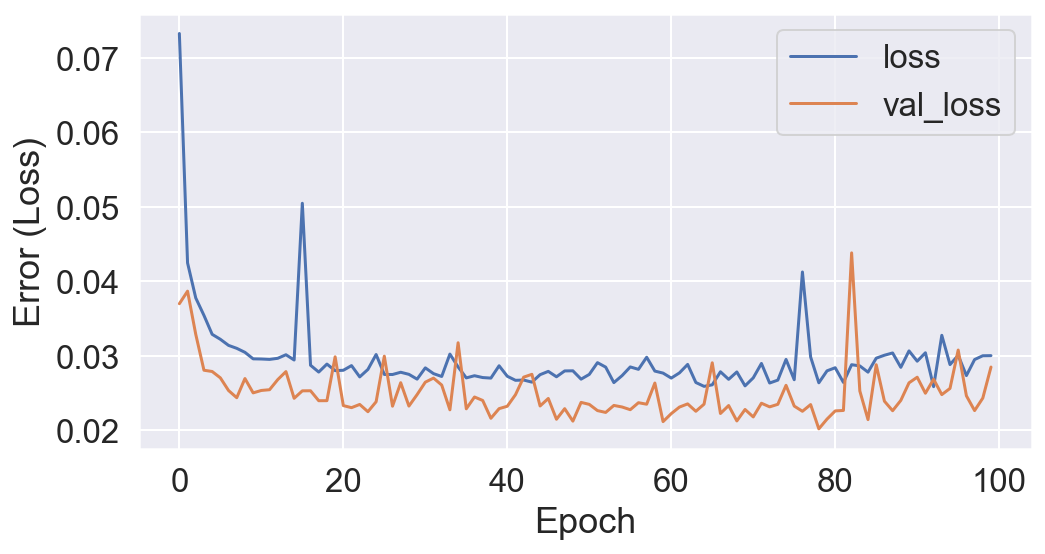

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error (Loss)')
plt.legend()
plt.grid(True)

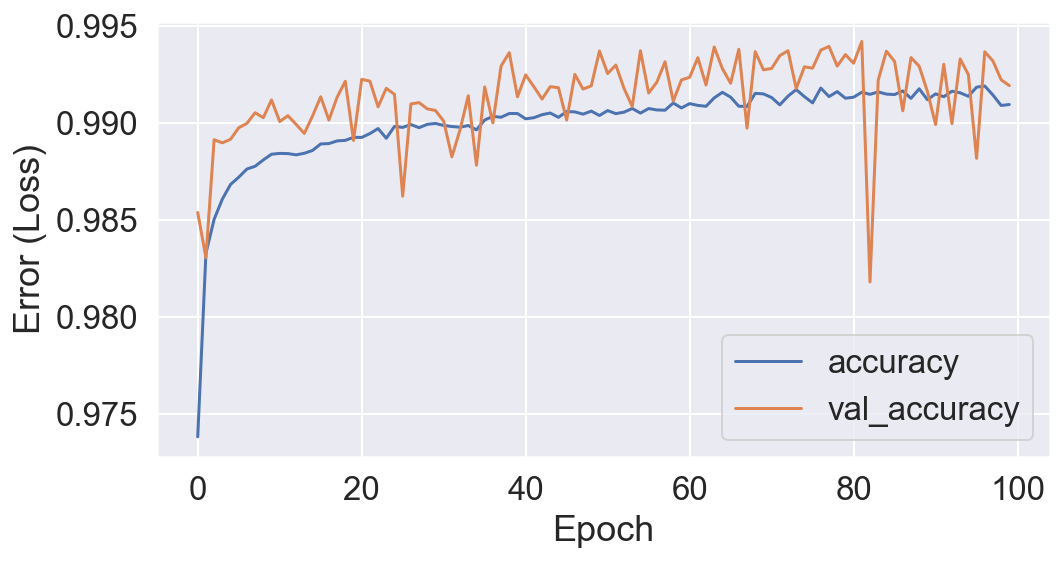

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Error (Loss)')
plt.legend()
plt.grid(True)

In [25]:
# Test trained model.
y_pred = seq_model.predict(x_test_std)

for pred in y_pred:
    for i, num in enumerate(pred):
        if num != 1.0000000e+00:
            pred[i] = 0.
        else:
            pred[i] = 1.

8704/8704 [==============================] - 9s 1ms/step


In [20]:
print(classification_report(y_test_ohe, y_pred, target_names=ohe.categories_[0]))

c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      benign       1.00      0.76      0.86    150796
         bot       0.00      0.00      0.00       584
 brute_force       1.00      0.00      0.00      2745
        ddos       1.00      0.64      0.78     38404
         dos       1.00      0.70      0.82     58124
    portscan       1.00      0.41      0.58     27208
  web_attack       0.00      0.00      0.00       643

   micro avg       1.00      0.68      0.81    278504
   macro avg       0.71      0.36      0.44    278504
weighted avg       1.00      0.68      0.80    278504
 samples avg       0.68      0.68      0.68    278504



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
